In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Zillow

Data provided by Zillow * Kaggle (see [here](https://www.kaggle.com/pratyushakar/zillow-zestimate#properties_2017.csv))

In [2]:
data_url = "https://docs.google.com/spreadsheets/d/198EG3tckqzD1uOKSYxAY62i5v_0LIZQMgzaIae6u1vo/export?format=csv"

<IPython.core.display.Javascript object>

Load all the usual suspects and some new ones including: `AgglomerativeClustering`, `DBSCAN`, `dendrogram`.

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

Function that will also be used in your exercise to produce a dendrogram from our `AgglomerativeClustering` object.

In [4]:
def plot_dendrogram(model, **kwargs):
    """
    A function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.

    Output: a dendrogram based on the model based in the parameters.

    Returns: None
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<IPython.core.display.Javascript object>

Read data and do some inspection & cleaning.

In [5]:
zillow = pd.read_csv(data_url)
zillow.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,17291058,NaN,NaN,8516.0,9.5,6,NaN,NaN,9.5,66.0,...,2.0,NaN,12956457,26879210,2016,13922753,283062.46,NaN,NaN,6.111007e+13
1,17214945,NaN,NaN,296.0,2.5,3,NaN,NaN,2.5,66.0,...,2.0,NaN,321000,1074000,2016,753000,11525.74,NaN,NaN,6.111005e+13
2,17060678,NaN,NaN,1146.0,6.5,4,NaN,NaN,6.5,66.0,...,2.0,NaN,1804157,2275709,2016,471552,24503.28,NaN,NaN,6.111001e+13
3,17284901,NaN,NaN,2322.0,1.5,6,NaN,NaN,1.5,66.0,...,3.0,NaN,4481348,7138171,2016,2656823,75722.34,NaN,NaN,6.111007e+13
4,17277746,NaN,NaN,182.0,3.5,4,NaN,NaN,3.5,66.0,...,2.0,NaN,254934,420023,2016,165089,4427.28,NaN,NaN,6.111006e+13


<IPython.core.display.Javascript object>

Drop columns that have more than 20% of their values missing.  How many columns does this remove?

In [6]:
perc_missing = zillow.isna().mean()
hi_missing = perc_missing[perc_missing > 0.2]

# uncomment to see values/names
# display(hi_missing.sort_values(ascending=False))

drop_cols = hi_missing.index
zillow = zillow.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

Drop all NAs from the dataframe.  How many rows does this remove?

In [7]:
zillow.shape

(15000, 34)

<IPython.core.display.Javascript object>

In [8]:
zillow = zillow.dropna()

<IPython.core.display.Javascript object>

In [9]:
zillow.shape

(12425, 34)

<IPython.core.display.Javascript object>

For the sake of time & plotting, downsample to 100 random records in the `zillow` dataframe.  Use a random seed of `42` to obtain consistent results.

In [10]:
# If we calc a distance matrix it will be 12425 * 12425 (154,380,625) elements large
# Let's down sample to have a quicker demo and a prettier dendrogram to look at
zillow = zillow.sample(100, random_state=42)
zillow.shape

zillow.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet50,fips,fireplacecnt,...,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
11325,17125395,4.0,5,4.0,1806.0,3705,3705.0,1806.0,6111,2.0,...,97089,10,2001.0,2.0,458000,1316000,2016,858000,15108.92,6.111005e+13
1766,17270065,3.0,5,3.0,2216.0,3642,3642.0,2216.0,6111,2.0,...,96351,10,1998.0,2.0,456219,726215,2016,269996,8078.32,6.111006e+13
14591,17222882,3.0,3,3.0,1565.0,2779,2779.0,1565.0,6111,2.0,...,97118,8,1988.0,2.0,324392,648784,2016,324392,7340.82,6.111008e+13
14939,17300793,3.0,3,3.0,1524.0,2902,2902.0,1524.0,6111,2.0,...,96342,7,1977.0,2.0,469425,1024253,2016,554828,11795.98,6.111008e+13
12049,17240329,3.0,4,3.0,1453.0,2295,2295.0,1453.0,6111,2.0,...,97116,8,1979.0,2.0,228144,380236,2016,152092,4799.22,6.111008e+13


<IPython.core.display.Javascript object>

Dropping a lot of columns based on being ID, having 0 variance, or being collinear (based on my understanding... rather than analysis... might be wrong).

In [11]:
# Id columns aren't too useful for clustering but we might want them later
# fmt: off
id_cols = ["parcelid", "pooltypeid7", "propertycountylandusecode", 
           "propertylandusetypeid", "regionidcity", "regionidcounty", "regionidzip",
           "latitude", "longitude", "fips",
           "rawcensustractandblock", "censustractandblock"]
zillow_sub = zillow.drop(columns=id_cols)

# Some columns that duplicate info
# Idk much about real estate so some of these might be bad assumptions
dup_cols = ["calculatedbathnbr", "finishedsquarefeet50", "finishedsquarefeet12",
            "finishedfloor1squarefeet", "structuretaxvaluedollarcnt", 
            "taxvaluedollarcnt", "landtaxvaluedollarcnt"]
# fmt: on
zillow_sub = zillow_sub.drop(columns=dup_cols)

# My random sample (using 42 as seed) had 0 variance in these 2 columns
no_var_cols = ["poolcnt", "assessmentyear"]
zillow_sub = zillow_sub.drop(columns=no_var_cols)

zillow_sub.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
11325,4.0,5,3705,2.0,4.0,4.0,948.0,59349.0,684.0,10,2001.0,2.0,15108.92
1766,3.0,5,3642,2.0,3.0,2.0,471.0,7720.0,640.0,10,1998.0,2.0,8078.32
14591,3.0,3,2779,2.0,3.0,2.0,659.0,11610.0,420.0,8,1988.0,2.0,7340.82
14939,3.0,3,2902,2.0,3.0,3.0,774.0,43560.0,525.0,7,1977.0,2.0,11795.98
12049,3.0,4,2295,2.0,3.0,2.0,487.0,8539.0,396.0,8,1979.0,2.0,4799.22


<IPython.core.display.Javascript object>

## Heirarchical Clustering

Links:
* [Greate resource here explaining an example in depth](http://www.econ.upf.edu/~michael/stanford/maeb7.pdf)
* [StatQuest video](https://www.youtube.com/watch?v=7xHsRkOdVwo): admittedly not his best work and not his best "bams"

#### Practicality ranking of different linkages:

(limited to avg, single, complete)

1. Average - Middle ground; great place to start
2. Complete - Can give more disparate clusters (might end up making points that were originally close together appear in different clusters)
3. Single - Will be biased towards making a "mega" cluster and then adding in outliers 1 by 1

----

* Ward - only applicable if euclidean distance is appropriate (numeric data) - great place to start if applicable

Prep data for clustering

In [12]:
scaler = StandardScaler()
scaled = scaler.fit_transform(zillow_sub)
scaled = pd.DataFrame(scaled, columns=zillow_sub.columns, index=zillow_sub.index)
scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
11325,0.641759,1.120951,0.292137,0.321897,0.950019,1.626534,1.062755,0.675226,1.048651,0.921299,1.213299,0.816497,0.624734
1766,-0.255806,1.120951,0.256025,0.321897,0.036539,-0.432370,-0.706772,-0.512082,0.729471,0.921299,1.005897,0.816497,-0.178307
14591,-0.255806,-1.315899,-0.238646,0.321897,0.036539,-0.432370,-0.009348,-0.422624,-0.866428,-0.195427,0.314559,0.816497,-0.262544
14939,-0.255806,-1.315899,-0.168142,0.321897,0.036539,0.597082,0.417267,0.312127,-0.104749,-0.753790,-0.445913,0.816497,0.246328
12049,-0.255806,-0.097474,-0.516074,0.321897,0.036539,-0.432370,-0.647417,-0.493248,-1.040527,-0.195427,-0.307646,0.816497,-0.552848


<IPython.core.display.Javascript object>

Calculate distance matrix

In [13]:
dist_mat = squareform(pdist(scaled, metric="euclidean"))
dist_mat = pd.DataFrame(dist_mat, index=scaled.index, columns=scaled.index)
dist_mat.head()

,11325,1766,14591,14939,12049,6551,12445,1176,7006,3980,...,9060,1351,12753,13125,2452,2869,5163,4317,9151,2153
11325,0.000000,3.348306,4.578582,4.053500,4.649586,4.510649,5.720689,4.629051,3.605171,4.899042,...,6.505565,4.811975,8.886839,3.979704,4.258759,5.075261,4.796224,2.748222,5.218322,4.666395
1766,3.348306,0.000000,3.310040,3.861429,2.886212,3.139493,4.154514,2.912746,1.735592,4.667685,...,5.125081,3.988176,7.634922,2.834333,2.743362,4.771451,3.365763,4.654137,3.335057,4.822543
14591,4.578582,3.310040,0.000000,1.875046,1.573331,3.059685,3.441136,2.081025,2.569361,2.908439,...,3.527489,4.694450,5.965963,2.088886,1.880516,4.863892,2.635877,5.119534,2.314954,4.366358
14939,4.053500,3.861429,1.875046,0.000000,2.508549,3.119016,3.549617,2.720650,3.135926,2.725889,...,3.520000,5.488207,5.568214,2.447868,2.439201,4.231623,3.128583,4.431397,3.014028,3.773120
12049,4.649586,2.886212,1.573331,2.508549,0.000000,3.076110,3.011393,1.864348,1.713908,3.233524,...,3.447616,3.998361,5.838851,1.637596,1.576541,4.653939,2.544483,5.548460,1.615128,5.040417


<IPython.core.display.Javascript object>

Perform heirarchical clustering with the distance matrix and [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [14]:
# If using one of their distances provided
# you can fit to original data instead of distance matrix

# clst = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="ward")
clst = AgglomerativeClustering(n_clusters=10, affinity="manhattan", linkage="complete")
clst.fit(scaled)

AgglomerativeClustering(affinity='manhattan', linkage='complete', n_clusters=10)

<IPython.core.display.Javascript object>

In [15]:
# If using a custom distance use your distance matrix as X and use affinity='precomputed'
clst = AgglomerativeClustering(
    n_clusters=10, affinity="precomputed", linkage="complete"
)
clst.fit(dist_mat)

AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=10)

<IPython.core.display.Javascript object>

Use the `plot_dendrogram()` helper function to plot the heirarchical clusters.

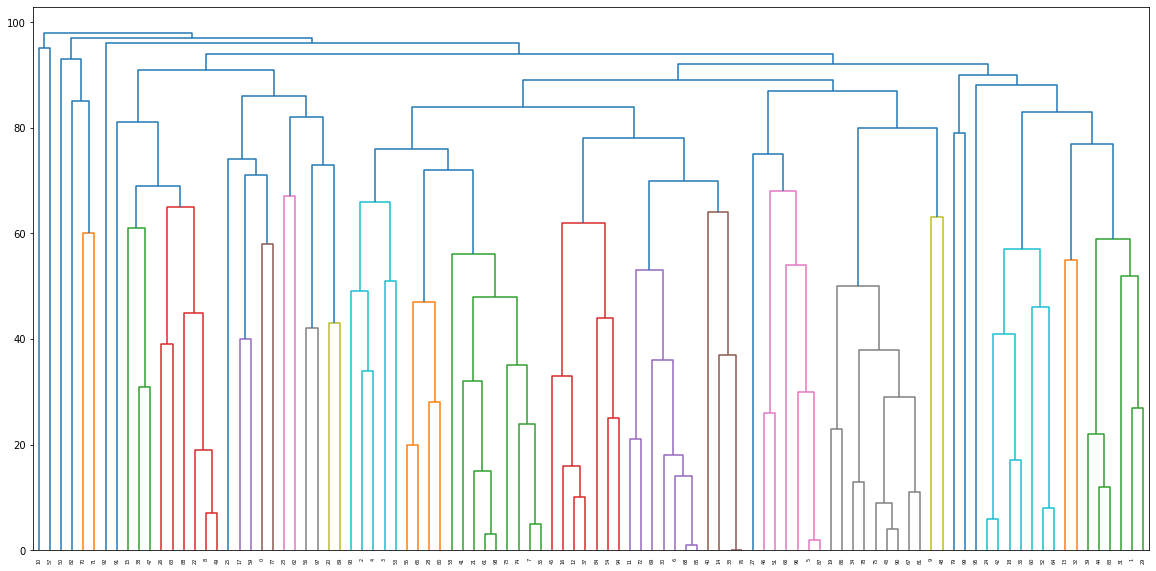

<IPython.core.display.Javascript object>

In [16]:
# sklearn didnt really intend for people to plot this
# this is a hacked together function
# THE Y AXIS DOES NOT LINE UP WITH ACTUAL DISTANCE VALUES

# if youre working with smaller data and dendrogram would be useful
# look into scipy.cluster.hierarchy.dendrogram()
# TODO: adam verify if remembered function correctly

plt.figure(figsize=(20, 10))
plot_dendrogram(clst)

Assign the cluster labels to a column in our original dataframe.

In [17]:
zillow_sub["label"] = clst.labels_
zillow_sub["label"] = "Cluster: " + zillow_sub["label"].astype(str)
zillow_sub["label"].value_counts()

Cluster: 0    54
Cluster: 1    16
Cluster: 2    11
Cluster: 3    10
Cluster: 5     3
Cluster: 4     2
Cluster: 7     1
Cluster: 6     1
Cluster: 8     1
Cluster: 9     1
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Interpret the clusters

In [18]:
clst_avgs = zillow_sub.groupby("label").mean()
clst_avgs.style.background_gradient()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
label,,,,,,,,,,,,,
Cluster: 0,2.629630,3.759259,2308.407407,1.370370,2.333333,2.055556,535.185185,15063.592593,482.111111,7.518519,1976.407407,1.462963,5674.563704
Cluster: 1,3.562500,4.437500,3453.187500,2.250000,3.187500,2.000000,634.875000,17445.437500,664.312500,8.687500,1990.500000,1.812500,10529.801250
Cluster: 2,4.454545,4.090909,4611.545455,1.909091,4.090909,3.636364,920.000000,62403.909091,610.181818,9.181818,1996.727273,1.545455,15708.941818
Cluster: 3,3.900000,4.900000,3453.500000,1.800000,3.600000,2.000000,625.800000,17355.700000,393.200000,9.400000,1993.600000,2.000000,8671.322000
Cluster: 4,2.500000,3.500000,3772.000000,1.500000,2.000000,3.000000,794.000000,76555.500000,836.000000,8.000000,1993.000000,1.000000,19502.850000
Cluster: 5,5.166667,5.333333,5123.666667,3.000000,4.666667,4.666667,1368.333333,164657.000000,746.666667,11.000000,1992.333333,2.000000,16223.740000
Cluster: 6,5.000000,3.000000,4361.000000,4.000000,5.000000,3.000000,864.000000,230432.000000,800.000000,7.000000,1987.000000,2.000000,24757.640000
Cluster: 7,6.500000,5.000000,10188.000000,4.000000,6.000000,8.000000,2204.000000,81022.000000,800.000000,12.000000,2004.000000,2.000000,72020.940000
Cluster: 8,1.500000,2.000000,1624.000000,1.000000,1.000000,2.000000,432.000000,10980.000000,525.000000,6.000000,1923.000000,1.000000,4713.720000


<IPython.core.display.Javascript object>

In [19]:
clst_avgs.iloc[:4].style.background_gradient()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
label,,,,,,,,,,,,,
Cluster: 0,2.629630,3.759259,2308.407407,1.370370,2.333333,2.055556,535.185185,15063.592593,482.111111,7.518519,1976.407407,1.462963,5674.563704
Cluster: 1,3.562500,4.437500,3453.187500,2.250000,3.187500,2.000000,634.875000,17445.437500,664.312500,8.687500,1990.500000,1.812500,10529.801250
Cluster: 2,4.454545,4.090909,4611.545455,1.909091,4.090909,3.636364,920.000000,62403.909091,610.181818,9.181818,1996.727273,1.545455,15708.941818
Cluster: 3,3.900000,4.900000,3453.500000,1.800000,3.600000,2.000000,625.800000,17355.700000,393.200000,9.400000,1993.600000,2.000000,8671.322000


<IPython.core.display.Javascript object>

In [20]:
zillow[zillow_sub["label"] == "Cluster: 0"].head()

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet50,fips,fireplacecnt,...,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
14591,17222882,3.0,3,3.0,1565.0,2779,2779.0,1565.0,6111,2.0,...,97118,8,1988.0,2.0,324392,648784,2016,324392,7340.82,6.111008e+13
14939,17300793,3.0,3,3.0,1524.0,2902,2902.0,1524.0,6111,2.0,...,96342,7,1977.0,2.0,469425,1024253,2016,554828,11795.98,6.111008e+13
12049,17240329,3.0,4,3.0,1453.0,2295,2295.0,1453.0,6111,2.0,...,97116,8,1979.0,2.0,228144,380236,2016,152092,4799.22,6.111008e+13
6551,17287190,2.5,4,2.5,2502.0,2502,2502.0,2502.0,6111,2.0,...,96393,8,1987.0,1.0,592633,1185266,2016,592633,14373.32,6.111007e+13
12445,17248903,2.0,4,2.0,1717.0,1717,1717.0,1717.0,6111,1.0,...,97118,7,1971.0,1.0,215651,342776,2016,127125,4060.88,6.111008e+13


<IPython.core.display.Javascript object>

In [21]:
# sns.pairplot(zillow_sub.iloc[:, -5:], hue="label")
# plt.show()

<IPython.core.display.Javascript object>

## DBSCAN Clustering

Links:
* [A cool demo animation](https://www.youtube.com/watch?v=h53WMIImUuc&feature=youtu.be&t=2)
* [Video to try and slow down and discuss the process shown in the animation animation](https://youtu.be/xzPh9R52xDs)

Perform clustering with [`sklearn.cluster.DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

In [22]:
# Not a great way to set an informed starting eps here
# Potentially use percentile as a way to make a somewhat
# informed starting eps
np.percentile(dist_mat, 10)

2.228413948828053

<IPython.core.display.Javascript object>

In [23]:
clst = DBSCAN(eps=2, min_samples=5, metric="euclidean")
clst.fit(scaled)

DBSCAN(eps=2)

<IPython.core.display.Javascript object>

Assign the labels to the dataframe

In [24]:
zillow_sub["label"] = clst.labels_
zillow_sub["label"] = "Cluster: " + zillow_sub["label"].astype(str)

<IPython.core.display.Javascript object>

In [25]:
dbscan_clusters = zillow_sub[zillow_sub["label"] != "Cluster: -1"]
dbscan_clusters["label"].value_counts()

Cluster: 0    46
Cluster: 1    23
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Perform clustering with DBSCAN using the distance matrix (with the same `eps` and `min_samples`.

In [26]:
# Precompute if not using a typical distance
# (ie always precompute for cat or mixed)
clst = DBSCAN(eps=2, min_samples=5, metric="precomputed")
clst.fit(dist_mat)

DBSCAN(eps=2, metric='precomputed')

<IPython.core.display.Javascript object>

Confirm you get the same results

In [27]:
zillow_sub["label"] = clst.labels_
zillow_sub["label"] = "Cluster: " + zillow_sub["label"].astype(str)

<IPython.core.display.Javascript object>

In [28]:
dbscan_clusters = zillow_sub[zillow_sub["label"] != "Cluster: -1"]
dbscan_clusters["label"].value_counts()

Cluster: 0    46
Cluster: 1    23
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Interpret the clusters

In [29]:
clst_avgs = dbscan_clusters.groupby("label").mean()
clst_avgs.style.background_gradient()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
label,,,,,,,,,,,,,
Cluster: 0,3.097826,4.173913,2844.239130,1.717391,2.782609,2.043478,587.347826,12953.456522,492.869565,8.195652,1983.847826,2.000000,7052.848261
Cluster: 1,2.434783,3.739130,2085.304348,1.173913,2.173913,2.000000,499.173913,15811.782609,511.695652,7.347826,1972.565217,1.000000,5420.509565


<IPython.core.display.Javascript object>

Change the values of `eps` and `min_samples` and repeat the analysis.